## Load the dataset

In [1]:
import json, gzip
import numpy as np

aa2idx = {'A':0, 'R':1, 'N':2, 'D':3, 'C':4, 'Q':5, 'E':6, 'G':7, 'H':8, 'I':9,
          'L':10, 'K':11, 'M':12, 'F':13, 'P':14, 'S':15, 'T':16, 'W':17, 'Y':18, 'V':19}

# read .json file
with gzip.open('../data/phipsi.json.gz', 'rb') as f:
    dataset = json.load(f)

# reduse dataset to a list for simpler access
dataset = dataset['phipsi10882']

# convert data to numpy arrays skipping first and last residues
for item in dataset:
    n = len(item['sequence'])
    item['sequence'] = np.array([aa2idx[aa] for aa in item['sequence'][1:n-1]], dtype=np.int8)
    item['phi'] = np.array(item['phi'], dtype=np.float32)[1:n-1]
    item['psi'] = np.array(item['psi'], dtype=np.float32)[1:n-1]

Set angle vector **v**=(cos(&phi;),sin(&phi;),cos(&psi;),sin(&psi;)) for every dihedral angle pair (&phi;,&psi;)

In [2]:
for item in dataset:
    item['avec'] = np.vstack([
        np.sin(item['phi']).T,
        np.cos(item['phi']).T,
        np.sin(item['psi']).T,
        np.cos(item['psi']).T ]).T

## Train / test / validation split

In [3]:
from sklearn.model_selection import train_test_split

train,buf = train_test_split(dataset, test_size=0.1, random_state=42)
test,validation = train_test_split(buf, test_size=0.5, random_state=42)

print("Train size: {} proteins".format(len(train)))
print("Test size: {} proteins".format(len(test)))
print("Validation size: {} proteins".format(len(validation)))

Train size: 9793 proteins
Test size: 544 proteins
Validation size: 545 proteins


## K-means clusters from angle vectors

In [4]:
from sklearn.cluster import KMeans
#from sklearn.cluster import MiniBatchKMeans

X = np.vstack([item['avec'] for item in train])

#kmeans = MiniBatchKMeans(n_clusters=20, batch_size=500, max_iter=100).fit(X)
# cluster the train set
kmeans = KMeans(n_clusters=20, max_iter=3)
kmeans.fit(X)

# assign clusters to data points
X_pred = kmeans.predict(X)

Convert centers of clusters to angles

In [5]:
cent = kmeans.cluster_centers_
cphi = np.arctan2(cent[:,0], cent[:,1])
cpsi = np.arctan2(cent[:,2], cent[:,3])

Visualize clusters

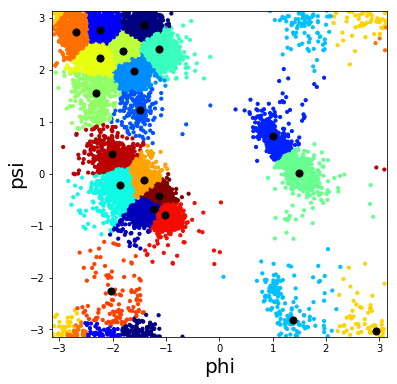

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# stack phi and psi from all proteins together
phi = np.hstack([item['phi'] for item in train])
psi = np.hstack([item['psi'] for item in train])

matplotlib.rcParams['image.cmap'] = 'jet'

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.xlabel('phi', fontsize=20)
plt.ylabel('psi', fontsize=20)
plt.scatter(phi[::100], psi[::100], c=X_pred[::100], s=10)
plt.scatter(cphi, cpsi, c='black', s=50)
plt.show()